In [1]:
%matplotlib inline
import utils
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from patch_manager import ImagePatchManager

## Load Data

In [2]:
ROOT_DIR = 'training/'
IMAGE_DIR = ROOT_DIR + 'images/'
files = os.listdir(IMAGE_DIR)

imgs = [utils.load_image(IMAGE_DIR + file) for file in files]

GT_DIR = ROOT_DIR + 'groundtruth/'

gt_imgs = [utils.load_image(GT_DIR + file) for file in files]

In [3]:
PATCH_SIZE = 16
images = ImagePatchManager(imgs, PATCH_SIZE)
gts = ImagePatchManager(gt_imgs, PATCH_SIZE)

In [4]:
x_train = np.array(images.get_p(0, len(images) - 1, map_f=utils.extract_features))
y_train = np.array(gts.get_p(0, len(images) - 1, map_f=utils.patch_to_class))

In [5]:
X_var = Variable(torch.from_numpy(np.stack(imgs))) # tensor (N, W, H, C)

In [32]:
Y_var = Variable(torch.from_numpy(np.stack(gt_imgs)))

In [26]:
Y_var = Variable(torch.from_numpy(np.stack(y_train)).type(torch.LongTensor))

In [27]:
Y_var

Variable containing:
 0
 0
 0
⋮ 
 1
 0
 0
[torch.LongTensor of size 62500]

In [5]:
x_train.shape

(62500, 6)

In [6]:
y_train.shape

(62500,)

## Load test image

In [7]:
img = images.get(20)
gt = gts.get(20)
x_test = np.array(images.get_p(20, map_f=utils.extract_features))

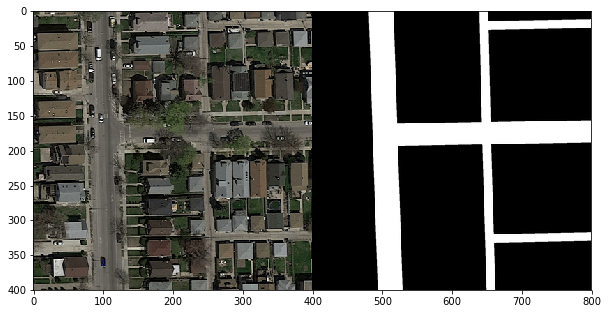

In [8]:
showr = utils.concatenate_images(img, gt)
plt.figure(figsize=(10, 10))
plt.imshow(showr)

## Training functions

In [33]:
def train(features, labels, model, lossfunc, optimizer, num_epoch):
    x = features
    y = labels
    for epoch in range(num_epoch):

        # TODO: Step 2 - compute model predictions and loss
        preds = model(x)
        loss = lossfunc(preds, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' 
                   %(epoch+1, num_epoch, loss.data[0]))

def get_pred(probs, threshold=0.5):
        probs[probs < threshold] = 0
        probs[probs >= threshold] = 1
        return probs

In [39]:
class NWHCtoNCWH(nn.Module):
    def __init__(self):
        super(NWHCtoNCWH, self).__init__()
    def forward(self, x):
        return x.permute(0, 3, 1, 2)

class NCWHtoNWHC(nn.Module):
    def __init__(self):
        super(NCWHtoNWHC, self).__init__()
    def forward(self, x):
        return x.permute(0,2,3,1)
    
class Squeezer1(nn.Module):
    def __init__(self):
        super(Squeezer1, self).__init__()
    def forward(self, x):
        return x.squeeze(dim=1)

In [40]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            NWHCtoNCWH(),
            nn.Conv2d(in_channels=3,
              out_channels=3,
              kernel_size=3,
              stride=1,
              padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=3,
              out_channels=3,
              kernel_size=3,
              stride=1,
              padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(2), NCWHtoNWHC())
        self.fc = nn.Linear(30000, 1)
        self.resize = nn.Sequential(
            NWHCtoNCWH(), # Return to N,C,W,H so that Upsame can rescale patch to whole image
            nn.Upsample(scale_factor=8),
            Squeezer1() # From N,1,W,H to N,W,H
)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.resize(out)
        return out


    
# TODO: Play with learning rate, hidden size, and optimizer type for multi-layered perceptron
hidden_size = 2
learning_rate = 1e-3

cnn = CNN()


# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

train(features = X_var,
      labels = Y_var,
      model = cnn,
      lossfunc = criterion,
      optimizer = optimizer,
      num_epoch = 100)

RuntimeError: invalid argument 1: input is not contiguous at /Users/soumith/miniconda2/conda-bld/pytorch_1503975723910/work/torch/lib/TH/generic/THTensor.c:231

In [ ]:
cnn.eval()

In [ ]:
outputs = cnn(x_test)
_, predicted = torch.max(outputs.data, 1)

/Users/Alexis/Desktop/MachineLearning-RoadSegmentation/utils.py:14: RuntimeWarning: invalid value encountered in true_divide
  rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8) # Pass from [0,1]f to [0,255]i


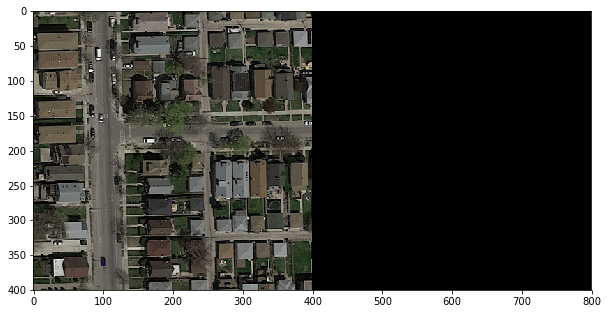

In [70]:
predicted_im = utils.label_to_img(gt.shape[0], gt.shape[1], PATCH_SIZE, PATCH_SIZE, labs.numpy())

cimg = utils.concatenate_images(img, predicted_im)
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')